## pickling the ELG c003 cosmology clustering measurements for doing constraints 

['A_s', 'H0', 'N_eff', 'N_ncdm', 'N_ur', 'Omega0_Lambda', 'Omega0_b', 'Omega0_cdm', 'Omega0_dcdm', 'Omega0_de', 'Omega0_fld', 'Omega0_g', 'Omega0_k', 'Omega0_m', 'Omega0_ncdm', 'Omega0_ncdm_tot', 'Omega0_pncdm', 'Omega0_pncdm_tot', 'Omega0_r', 'Omega0_ur', 'Omega_Lambda', 'Omega_b', 'Omega_cdm', 'Omega_dcdm', 'Omega_de', 'Omega_fld', 'Omega_g', 'Omega_k', 'Omega_m', 'Omega_ncdm', 'Omega_ncdm_tot', 'Omega_pncdm', 'Omega_pncdm_tot', 'Omega_r', 'Omega_ur', 'T0_cmb', 'T0_ncdm', 'T_cmb', 'T_ncdm', '_RH0_', '__copy__', '__dict__', '__getattr__', '__getitem__', '__module__', '__pyx_vtable__', '__weakref__', '_check_pk_of', '_default_calculation_parameters', '_default_cosmological_parameters', '_derived', '_engine', '_get_p_ncdm', '_get_rho_ncdm', '_get_z', '_has_fld', '_index_pk_of', '_input_params', '_params', '_use_pk_non_linear', 'age0', 'alpha_s', 'angular_diameter_distance', 'clone', 'comoving_angular_distance', 'comoving_radial_distance', 'conformal_time', 'copy', 'cs2_fld', 'data', 'ef

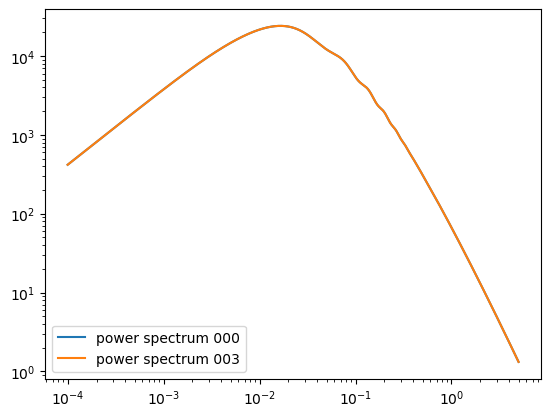

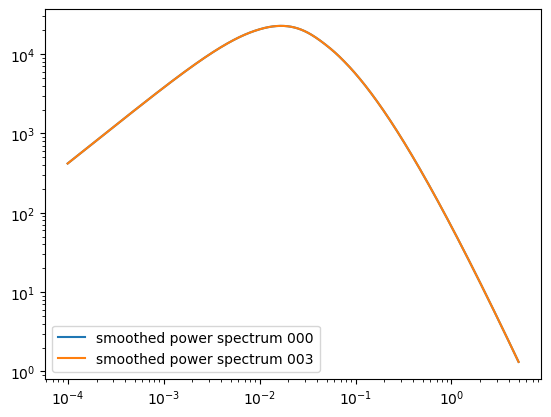

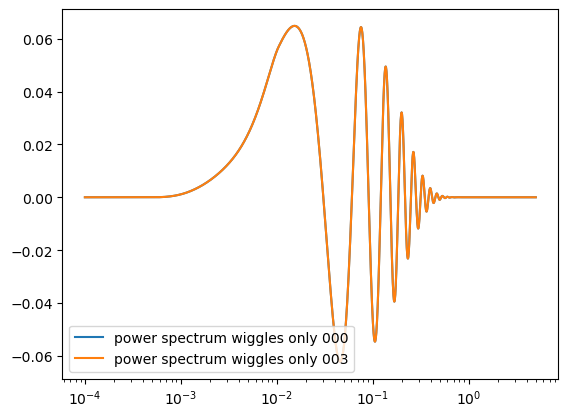

In [5]:
# Import the necessary packages and set up the fiducial cosmology
import os
import pickle
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from cosmoprimo.fiducial import DESI, AbacusSummit # package interface for CLASS and CAMB 
from scipy.interpolate import splrep, splev
from cosmoprimo import PowerSpectrumBAOFilter
from pypower import BaseMatrix, PowerSpectrumMultipoles, PowerSpectrumSmoothWindow, PowerSpectrumSmoothWindowMatrix, PowerSpectrumOddWideAngleMatrix, setup_logging
from pycorr import TwoPointCorrelationFunction, project_to_multipoles
cosmo = DESI() # initialize CLASS/CAMB like object for doing calculations of power spectrum etc. 

print(dir(cosmo))


from matplotlib import rc
import matplotlib
plt.style.use('default')
from statsmodels.stats.moment_helpers import cov2corr

# commenting out code that produces template - we already have this because we will analyse assuming the 000 model? 

# -------------------------------------------------------------------------------------------------------------------------------

print(cosmo.A_s, cosmo.H0, cosmo.Omega0_b, cosmo.n_s, cosmo.N_eff, cosmo.Omega0_m, cosmo.tau_reio)
# Save the default DESI template to a file - added in code here to make sure the template is prepared properly 
k_min = 1e-4
k_max = 5
k_num = 2000
kl = np.logspace(np.log(k_min), np.log(k_max), k_num, base=np.e)
pkz = cosmo.get_fourier().pk_interpolator() # object to get power spectrum from interpolator 
pk = pkz.to_1d(z=0) # get power spectrum at z = 0 
pkv = pk(kl) 
# plt.loglog(kl, pkv, label='power spectrum') # full broadband power spectrum + wiggles
# plt.legend()
# plt.show()
pknow = PowerSpectrumBAOFilter(pk, engine='wallish2018').smooth_pk_interpolator()
pksmv = pknow(kl) # interpolate smoothed power spectrum at desired k values 
# plt.loglog(kl, pksmv, label='smoothed power spectrum') # smoothed broadband power spectrum without the wiggles (smoothed out) 
# plt.legend()
# plt.show()
np.savetxt("DESI_Pk_template.dat", np.c_[kl, pksmv, pkv/pksmv - 1.0],  fmt="%g %g %g", header="k     pk_smooth     pk_ratio") # saving 
# the smoothed power spectrum and the ratio of the smooth to original to get the wiggles only - gets used later 

# preparing template for cosmology 003 
# cosmo.N_eff = 3.7#044
# cosmo.A_s = 2.2438e-9
# cosmo.H0 = 71.60
# cosmo.Omega0_b = 0.0226 / (0.716**2)
# cosmo.n_s = 0.9876
# cosmo.Omega0_m = (0.0226 + 0.1291) / (0.716**2)
# print(cosmo.A_s, cosmo.H0, cosmo.Omega0_b, cosmo.n_s, cosmo.N_eff, cosmo.Omega0_m, cosmo.tau_reio)
cosmo = AbacusSummit(name='003')

pkz3 = cosmo.get_fourier().pk_interpolator() # object to get power spectrum from interpolator 
pk3 = pkz3.to_1d(z=0) # get power spectrum at z = 0 
pkv3 = pk3(kl) 
pknow3 = PowerSpectrumBAOFilter(pk3, engine='wallish2018').smooth_pk_interpolator()
pksmv3 = pknow3(kl)
np.savetxt("DESI_Pk_template_c003.dat", np.c_[kl, pksmv3, pkv3/pksmv3 - 1.0],  fmt="%g %g %g", header="k     pk_smooth     pk_ratio") # saving 



plt.loglog(kl, pkv, label='power spectrum 000') # full broadband power spectrum + wiggles
plt.loglog(kl, pkv3, label='power spectrum 003') # full broadband power spectrum + wiggles
plt.legend()
plt.show()

plt.loglog(kl, pksmv, label='smoothed power spectrum 000') # smoothed broadband power spectrum without the wiggles (smoothed out)
plt.loglog(kl, pksmv3, label='smoothed power spectrum 003') # smoothed broadband power spectrum without the wiggles (smoothed out) 
plt.legend()
plt.show()

plt.semilogx(kl, pkv/pksmv - 1.0, label='power spectrum wiggles only 000')
plt.semilogx(kl, pkv3/pksmv3 - 1.0, label='power spectrum wiggles only 003')
plt.legend()
plt.show()


def plot_cov(matrix):
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    ''' Plot the correlation matrix derived from the covariance matrix '''
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.imshow(cov2corr(matrix), cmap=plt.get_cmap('bwr'))
    plt.colorbar()
    plt.clim(-1,1)
    plt.show()
    return 
# -------------------------------------------------------------------------------------------------------------------------------


## modified power spectrum routines - using others code with some modifications 

In [5]:
# Power Spectrum. By Cristhian Garcia-Quintero, here we use an already rebinned Pk multipoles .txt file with the k-values and multipoles in a single file. Barry needs 5 even+odd multipoles, but the odd ones can be filled with zeros if these haven't been measured, as is done here.
# modifications I have made to old code have been largely just commented out 
def getpk_cgq(loc, zname, CV, post=False):
    seed = ["0", "1", "2", "3", "4", "5"]#, "06", "07", "08", "09", # only have 6 mocks atm 
           # "10", "11", "12", "13", "14", "15", "16", "17", "18", "19",
           #  "20", "21", "22", "23", "24"]
    res = []
    nmocks = len(seed)
    for i in range(nmocks): # looping through mocks and opening up - also think we dn't have CV? 
        # Read data for a single mock
        # if (CV == True and post==True):
        #     mydata = open(loc + '/' + zname + seed[i] + '.gcat_MultiGrid_mesh1024_smooth15_recsym_b1.2_randoms_20X.Pk_nmesh1152.ecsv', 'r')
        # elif (CV == True and post==False):
        #     mydata = open(loc + '/' + zname + seed[i] + '.gcat.Pk_nmesh1152.ecsv', 'r')
        # else:
        #mydata = open(loc + '/' + zname + seed[i] + '.npy', 'r') 
        
        
        # unfortunately I can only seem to open the files in a strange kind of way, 
        #dat = np.load(loc+zname+seed[i]+'.npy', allow_pickle=True)
        #d = dat[()] # weird way to read in the files .... but this odd syntax seems to work 
        
        poles = PowerSpectrumMultipoles.load(loc+zname+seed[i]+'.npy')
        poles.slice(slice(0, 800))
        poles.rebin(5)
        k, pkell = poles(ell=(0,2,4), return_k=True, complex=False)
        pk0, pk2, pk4 = pkell
        
        bools = np.logical_not(np.isnan(k))
        k = k[bools]

        pk0 = pk0[bools]
        pk2 = pk2[bools]
        pk4 = pk4[bools]

        #lines=mydata.readlines()
        #k  = []
        #P0 = []
        
        # k = np.array((d['modes'][0]))
        # P0 = np.array((d['power_nonorm'][0]))
        # P0 = abs(P0[k != np.nan])
        # k = k[k != np.nan]
        
        
        #P2 = [] # think we only have monopole atm 
        #P4 = []
        # for line in lines: # looping through lines in file to save k, monopole, quadrupole and hexadecapole 
        #     if line.startswith('#'):
        #         if line[4:17]=='galaxy_number':
        #             num_gal = float(line.split()[2])
        #             num_ran = num_gal * 20
        #             boxsize = 2000
        #             nbar_gal = num_gal/boxsize**3
        #             nbar_ran = num_ran/boxsize**3
        #             shot_noise_gal = 1/nbar_gal
        #             shot_noise_ran = 1/nbar_ran
        #             shot_noise = shot_noise_gal + shot_noise_ran
        #             print("num_gal:", num_gal, "nbar_gal:", nbar_gal, "Shot-Noise:", shot_noise)
        #     else:
        #         if (CV == True):
        #             k.append(line.split()[0]) 
        #             P0.append(line.split()[1]) 
        #             P2.append(line.split()[2]) 
        #             P4.append(line.split()[3]) 
        #         elif (post == True):
        #             k.append(line.split()[1]) 
        #             P0.append(line.split()[3]) 
        #             P2.append(line.split()[5]) 
        #             P4.append(line.split()[7]) 
        #         else:
        #             k.append(line.split()[1]) 
        #             P0.append(line.split()[3]) 
        #             P2.append(line.split()[4]) 
        #             P4.append(line.split()[5]) 
        # mydata.close()
        # if (CV == True):
        #     k=k[1:]
        #     P0=P0[1:]
        #     P2=P2[1:]
        #     P4=P4[1:]
        # k  = np.array([float(i) for i in k])    
        # P0 = np.array([float(i) for i in P0])    
        # P2 = np.array([float(i) for i in P2])    
        # P4 = np.array([float(i) for i in P4])   
        # Append 5 multipoles to result
        df = {}
        df["k"] = k
        # if (CV == True):
        #     df[f"pk0"] = P0 - shot_noise
        # else:
        df[f"pk0"] = pk0
        df[f"pk2"] = pk2
        df[f"pk4"] = pk4
        df["pk1"] = np.zeros(len(df["k"])) # in dataframe save odd multipoles as zeros 
        df["pk3"] = np.zeros(len(df["k"]))
        res.append(pd.DataFrame(df)[["k", "pk0", "pk1", "pk2", "pk3", "pk4"]])
         
    return res



# rest of this code is unmodified from original code -----

# Window function matrix. The window functions are stored in a dictionary of 'step sizes' i.e., how many bins get stuck together relative to the 
# pk measurements so that we can rebin the P(k) at run time if required. Each step size is a dictionary with:
#    the input and output k binning (w_ks_input, w_ks_output), the window function matrix (w_transform) and integral constraint (w_k0_scale).
# The window function assumes 6 input and 5 output multipoles. For cubic sims, we can set the integral constraint to zero and window matrix to the identity matrix, as is done here.
def getwin_dummy(ks):
    res = {"w_ks_input": ks.copy(), "w_k0_scale": np.zeros(ks.size), "w_transform": np.eye(5 * ks.size, 6 * ks.size), "w_ks_output": ks.copy()}
    return {1: res}  # Step size is one

# The conversion matrix M from Beutler 2019. Used to compute the odd multipole models given the even multipoles. In the absence of wide angle effects, or if we don't care about
# the odd multipoles, we can set this to a block matrix with identity matrices in the appropriate places, as is done here.
def getcomp_dummy(ks):
    matrix = np.zeros((6 * ks.size, 3 * ks.size))
    matrix[: ks.size, : ks.size] = np.diag(np.ones(ks.size))
    matrix[2 * ks.size : 3 * ks.size, ks.size : 2 * ks.size] = np.diag(np.ones(ks.size))
    matrix[4 * ks.size : 5 * ks.size, 2 * ks.size :] = np.diag(np.ones(ks.size))
    return matrix



# Power spectrum covariance matrix. Needs to have 6 multipoles, but if the some of them haven't been measured, we can set the covariance matrix elements to the identity matrix, as is done here.
def format_pk_cov(nks, covfile):#, kvals=None):

    cov_input = pd.read_csv(covfile, comment="#", delim_whitespace=True, header=None).to_numpy()
    nin = nks
    cov = np.eye(5 * nks)
    cov[:nks, :nks] = cov_input[:nks, :nks]
    cov[:nks, 2 * nks : 3 * nks] = cov_input[:nks, nin : nin + nks]
    cov[:nks, 4 * nks : 5 * nks] = cov_input[:nks, 2 * nin : 2 * nin + nks]
    cov[2 * nks : 3 * nks, :nks] = cov_input[nin : nin + nks, :nks]
    cov[2 * nks : 3 * nks, 2 * nks : 3 * nks] = cov_input[nin : nin + nks, nin : nin + nks]
    cov[2 * nks : 3 * nks, 4 * nks : 5 * nks] = cov_input[nin : nin + nks, 2 * nin : 2 * nin + nks]
    cov[4 * nks : 5 * nks, :nks] = cov_input[2 * nin : 2 * nin + nks, :nks]
    cov[4 * nks : 5 * nks, 2 * nks : 3 * nks] = cov_input[2 * nin : 2 * nin + nks, nin : nin + nks]
    cov[4 * nks : 5 * nks, 4 * nks : 5 * nks] = cov_input[2 * nin : 2 * nin + nks, 2 * nin : 2 * nin + nks]
    
    plt.imshow(cov/np.sqrt(np.outer(np.diag(cov), np.diag(cov))))
    plt.imshow(cov[:nks,:nks]/np.sqrt(np.outer(np.diag(cov[:nks,:nks]), np.diag(cov[:nks,:nks]))))
    
    plt.show()
    
    # Check the covariance matrix is invertible
    v = np.diag(cov @ np.linalg.inv(cov))
    if not np.all(np.isclose(v, 1)):
        #print(np.sum(v))
        print("ERROR, setting an inappropriate covariance matrix that is almost singular!!!!")
        #print(f"These should all be 1: {v}")
    
    return cov


# this function is unmodified for now 
# Useful utility function to collate some Pk data - simple read in data for multipoles for pre and post reconstruction 
# also read in file for the window function of the data 
def collect_pk_data(pre_files, post_files, pre_cov_files, post_cov_files, winfile, zeff, prezname, postzname, name, CV=False):
    
    ks = None
    pre_cov, post_cov = None, None
    pre_data, post_data = None, None
    pre_mocks, post_mocks = None, None
    if pre_files is not None:
        pre_res = getpk_cgq(pre_files, prezname, CV, post=False) 
        ks = pre_res[0]["k"].to_numpy()
        pre_cov = format_pk_cov(len(ks), pre_cov_file)#, kvals=ks)
        pre_mocks = [v for v in pre_res]
    if post_files is not None:
        post_res = getpk_cgq(post_files, postzname, CV, post=True)
        ks = post_res[0]["k"].to_numpy() 
        post_cov = format_pk_cov(len(ks), post_cov_file)#, kvals=ks)
        post_mocks = [v for v in post_res]

    #if winfile is not None:
    #    winmat, wideangle = getwin(ks, winfile)
    #    wideangle = getcomp_dummy(ks)
    #else:
    winmat, wideangle = getwin_dummy(ks), getcomp_dummy(ks)
    
    split = {
        "n_data": 1,
        "pre-recon data": pre_data,
        "pre-recon cov": pre_cov,
        "post-recon data": post_data,
        "post-recon cov": post_cov,
        "pre-recon mocks": pre_mocks,
        "post-recon mocks": post_mocks,
        "cosmology": {
            "om": cosmo["Omega_m"],
            "h0": cosmo["h"],
            "z": zeff,
            "ob": cosmo["Omega_b"],
            "ns": cosmo["n_s"],
            "mnu": np.sum(cosmo["m_ncdm"]),
            "reconsmoothscale": 15,
        },
        "name": name,
        "winfit": winmat,
        "winpk": None,  # We can set this to None; Barry will set it to zeroes given the length of the data vector.
        "m_mat": wideangle,
    }
    
    with open(f"./" + name.lower().replace(" ", "_")+".pkl", "wb") as f:
        pickle.dump(split, f)
        
    return split # writing read in file sand other results that are relevant to pickle file and returning 



# Plot the power spectra, for sanity checking
def plot_pk(split, pre=True, post=True):
    
    if pre:
        color = ["r", "b", "g"]
        ks = split["pre-recon mocks"][0]["k"]
        nmocks = len(split["pre-recon mocks"])
        label = [r"$P_{0}(k)$", r"$P_{2}(k)$", r"$P_{4}(k)$"]
        for m, pk in enumerate(["pk0", "pk2", "pk4"]): # looping and plotting each multipole mean value 
            yerr = ks * np.sqrt(np.diag(split["pre-recon cov"]))[2 * m * len(ks) : (2 * m + 1) * len(ks)]
            plt.errorbar(
                ks,
                ks * np.mean([split["pre-recon mocks"][i][pk] for i in range(nmocks)], axis=0),
                yerr=yerr,
                marker="o",
                ls="None",
                c=color[m],
                label=label[m],
            )
            for i in range(nmocks): # each mock plotted multipole x ks array 
                plt.errorbar(ks, ks * split["pre-recon mocks"][i][pk], marker="None", ls="-", c='k', alpha=1.0 / nmocks**(3.0/4.0))
        plt.xlabel(r"$k$")
        plt.ylabel(r"$k\,P(k)$")
        plt.title(split["name"] + " Prerecon")
        plt.legend(loc='upper right')
        plt.show()
    
    if post:
        color = ["r", "b", "g"]
        ks = split["post-recon mocks"][0]["k"]
        nmocks = len(split["post-recon mocks"])
        label = [r"$P_{0}(k)$", r"$P_{2}(k)$", r"$P_{4}(k)$"]
        for m, pk in enumerate(["pk0", "pk2", "pk4"]):
            yerr = ks * np.sqrt(np.diag(split["post-recon cov"]))[2 * m * len(ks) : (2 * m + 1) * len(ks)]
            plt.errorbar(
                ks,
                ks * np.mean([split["post-recon mocks"][i][pk] for i in range(nmocks)], axis=0),
                yerr=yerr,
                marker="o",
                ls="None",
                c=color[m],
                label=label[m],
            )
            for i in range(nmocks):
                plt.errorbar(ks, ks * split["post-recon mocks"][i][pk], marker="None", ls="-", c='k', alpha=1.0 / nmocks**(3.0/4.0))
        plt.xlabel(r"$k$")
        plt.ylabel(r"$k\,P(k)$")
        plt.title(split["name"] + " Postrecon")
        plt.legend(loc='upper right')
        plt.show()

## produce pickles - prerecon, Pk only

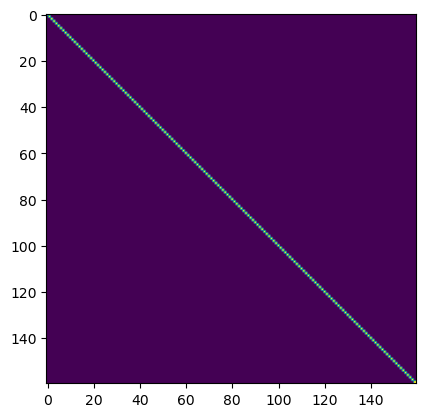

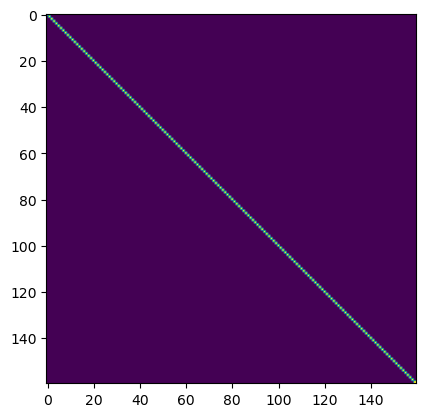

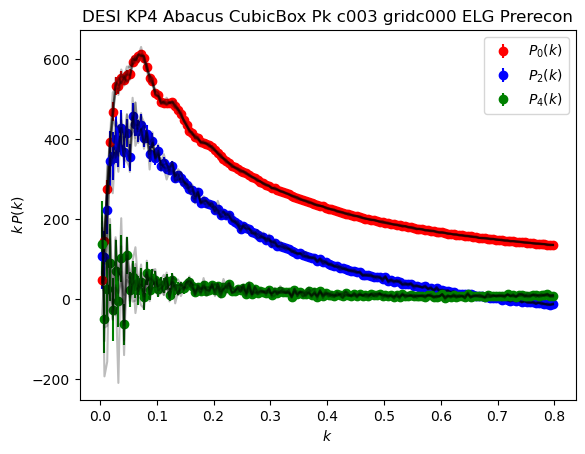

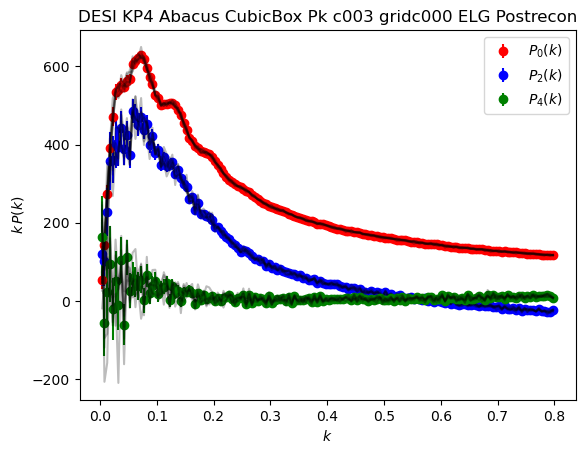

In [7]:
# Loop over tracers

#path_ezmock = "/global/homes/c/crisjagq/HOD_tests/covariance_matrices/EZMocks/" # assuming we can apply these covariances for this cosmology also 

path_cov = '/global/u2/c/crisjagq/HOD_tests/covariance_matrices/CovaPT/low_density/'
covfile = 'AnalyticCov_Gaussian_Pk_Abacus_CubicBox_hod_LNHOD.txt'

path_files = '/global/cfs/cdirs/desicollab/users/alexpzfz/KP4/fiducial_cosmo/CubicBox/Pk/ELG/AbacusSummit_base_c003_SV3/los_z/' # path to all mocks c003 we got 

filename_recon = 'Pk_ELG_snap16_multigrid_nmesh512_sm10_f0.888_b1.20_recsym_Grid000_ph00'#0.npy'

filename_prerecon = 'Pk_ELG_snap16_Grid000_ph00'#0.npy'


# Dictionary containing z for the tracers
reds = {"ELG": [1.1]}

for tracer in ["ELG"]:
    for i, z in enumerate(reds[tracer]):
    
        # Power Spectrum
        # pre reconstruction file paths 
        pre_file = path_files #+ filename_prerecon 
        
        pre_cov_file = path_cov + covfile#"EZmocks_ELG_CubicBox_z1p1_Pk_cov_matrix_reshaped_pk-pre.txt"  # Uses the EZmock covariance
        
        # post reconstruction file paths 
        post_file = path_files #+ filename_recon # was missing recsym directory initially 
        
        post_cov_file = path_cov + covfile# "EZmocks_ELG_CubicBox_z1p1_Pk_cov_matrix_reshaped_pk-pre.txt"  # Uses the Prerecon EZmock covariance
        
        name = f"DESI KP4 Abacus CubicBox Pk c003 gridc000 " + tracer
        
        data = collect_pk_data(pre_file, post_file, pre_cov_file, post_cov_file, None, z, filename_prerecon,
                               filename_recon, name, CV=False)
        
        plot_pk(data) # Plot the data to check things

        
        
        
    # no correlation function at the moment      
    
#         # Correlation Function
#         pre_file = path_abacus + tracer + f"/Xi/Pre/lhior/txt_rebinned"
#         pre_cov_file = path_ezmock + "EZmocks_ELG_CubicBox_z1p1_Xi_cov_matrix_reshaped-pre.txt"  # Uses the EZmock covariance
        
#         post_file = path_abacus + tracer + "/Xi/Post/lhior/RecSym_nmesh1024/txt_rebinned"
#         post_cov_file = path_ezmock + "EZmocks_ELG_CubicBox_z1p1_Xi_cov_matrix_reshaped-pre.txt"  # Uses the Prerecon EZmock covariance
        
#         name = f"DESI KP4 Abacus CubicBox Xi " + tracer
#         data = collect_xi_data(pre_file, post_file, pre_cov_file, post_cov_file, z, "Xi_AbacusSummit_base_c000_ph0",
#                                "Xi_AbacusSummit_base_c000_ph0", name)
#         plot_xi(data) # Plot the data to check things
        
        